In [1]:
BOXES_FILE = "../dataset_marseille/deepforest_pred_laplaine_boxes-IGN0.2m_patch400px_overlap0.15.csv"
GEOTIFF_PATH = "../dataset_marseille/satellite_raster_sample_laplaine_IGN_0.2m-resolution.tif"


PATCH_OUTPUT_DATASET="../dataset_marseille/deepforest_pred_laplaine_patches_IGN0.2m.jsonl"

PADDING=50 # pixel padding around a tree

# Saves patches of tree

load the csv file and return crops with trees and bounding box coords

In [2]:
import pandas as pd
import numpy as np
from PIL import Image

from deepforest import preprocess

from matplotlib import pyplot as plt
%matplotlib inline

import json

In [3]:
boxes = pd.read_csv(BOXES_FILE)

In [4]:
raster_path = GEOTIFF_PATH
raster = Image.open(raster_path)
numpy_image = np.array(raster)
numpy_image.shape

(3157, 5182, 4)

In [5]:
# we drop the alpha channel
numpy_image = numpy_image[:,:,:3]

### First idea 
export tiles and various trees on them
this doesn't work well

In [6]:
# windows = preprocess.compute_windows(numpy_image, patch_size=400,patch_overlap=0.15)

In [7]:
# # lets do a bad double for loop bc I'm out of ideas here 

# total_box=0
# for index, window in enumerate(windows):
#     crop = numpy_image[windows[index].indices()]
#     xmin, ymin, w, h = windows[index].getRect()
#     xmax = xmin + w
#     ymax = ymin + h
    
#     for box in boxes[["xmin", "ymin", "xmax", "ymax"]].values:
#         bxmin, bymin, bxmax, bymax = box
        
#         if bxmin >= xmin and bymin >= ymin and bxmax <= xmax and bymax <= ymax:
#             total_box += 1
#             #print("box found on crop")
#             #print("crop xmin ymin xmax ymax", xmin, ymin, xmax, ymax)
#             #print("box xmin ymin xmax ymax", bxmin, bymin, bxmax, bymax)
            
# print("found {} boxes on crops".format(total_box))

### Second idea
export little patches around each tree

In [8]:
import cv2

def draw_box(image, box, color=[0, 0, 255], thickness=1):
    """ Draws a box on an image with a given color.

    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)

In [17]:
def get_box_crop(numpy_image, box, padding=50):
    xmin, ymin, xmax, ymax = box
        
    # numpy_image is organized height, width, channels (or y, x, chan)
    image_xmax = numpy_image.shape[1]
    image_ymax = numpy_image.shape[0]
    
    crop_xmin = np.maximum(0, xmin - padding)
    crop_ymin = np.maximum(0, ymin - padding)
    crop_xmax = np.minimum(image_xmax, xmax + padding)
    crop_ymax = np.minimum(image_ymax, ymax + padding)
    
    box_coords_in_crop = (xmin - crop_xmin, ymin - crop_ymin, xmax - crop_xmin, ymax - crop_ymin)
    crop_coords = (crop_xmin, crop_ymin, crop_xmax, crop_ymax)
    
    return numpy_image[crop_ymin:crop_ymax,crop_xmin:crop_xmax,:], crop_coords, box_coords_in_crop

In [10]:
# index = 100
index = 10

box0 = boxes[["xmin", "ymin", "xmax", "ymax"]].values[index]
crop, crop_coords, crop_box_coords = get_box_crop(numpy_image, box0, padding=PADDING)

crop_with_box = crop.copy()
draw_box(crop_with_box, crop_box_coords)

(4363, 2806, 4514, 2956)
x max: 5182, y max: 3157


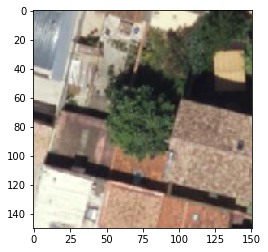

In [11]:
plt.imshow(crop)

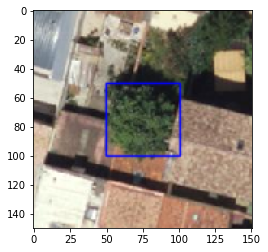

In [12]:
plt.imshow(crop_with_box)

## Export all the boxes in a good format for Prodi.gy

see: https://prodi.gy/docs/api-interfaces#image_manual

```
{
  "image": "https://images.unsplash.com/photo-1434993568367-36f24aa04d2f?w=400",
  "width": 400,
  "height": 267,
  "spans": [
    {
      "label":"SKATEBOARD",
      "color": "yellow",
      "x": 47.5,
      "y": 171.4,
      "width": 109.1,
      "height": 67.4,
      "points": [[47.5, 171.4], [47.5, 238.8], [156.6, 238.8], [156.6, 171.4]],
      "center": [102.05, 205.1],
      "type": "rect"
    },
    {
      "label": "PERSON",
      "color": "cyan",
      "points": [[256, 39.5], [237, 78.5], [269, 116.5], [286, 67.5]],
      "type": "polygon"
    }
  ]
}```

In [13]:
import io
import base64

def numpy_img_to_encoded(numpy_image):
    ''' existing open im to encoded '''
    buffer = io.BytesIO()
    im = Image.fromarray(numpy_image)
    im.save(buffer, "JPEG")
    data64 = base64.b64encode(buffer.getvalue())
    image_encoded = "data:image/jpeg;base64,{}".format(
        data64.decode("utf-8"))
    return image_encoded

In [14]:
def get_four_corners(xmin, ymin, xmax, ymax):
    ''' get four corners of the rectangle which is what `image` ui takes in prodigy'''
    return [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]

In [18]:
dataset = []


for index, box in enumerate(boxes[["xmin", "ymin", "xmax", "ymax"]].values):
    xmin, ymin, xmax, ymax = box

    crop, crop_coords, crop_box_coords = get_box_crop(numpy_image, box, padding=PADDING)
    
    bxmin, bymin, bxmax, bymax = crop_box_coords
    cxmin, cymin, cxmax, cymax = crop_coords
    
    crop_encoded = numpy_img_to_encoded(crop)
    
    dataset_entry = { 
        "image": crop_encoded,
        "width": crop.shape[0],
        "height": crop.shape[1],
        
        "tile_crop_coordinates": { "xmin": int(cxmin), "ymin": int(cymin), "xmax": int(cxmax), "ymax": int(cymax) },
        
        "spans": [
            { 
#                "label": "tree",
                
               # type "rect" and x, y width, height only works well with `image.manual` UI in prodi.gy
               "type": "rect", 
               "x": int(bxmin),
               "y": int(bymin),
               "width": int(bxmax - bxmin),
               "height": int(bymax - bymin),
                
               # "points" work better for a `choice` UI in prodi.gy
               "points": get_four_corners(int(bxmin), int(bymin), int(bxmax), int(bymax)),
             
               # original coordinates
               "tile_box_coordinates": { "xmin": int(xmin), "ymin": int(ymin), "xmax": int(xmax), "ymax": int(ymax) },
             
               ## TODO also add lat, lon coordinates in epsg:3857
             
            }],
    }
    dataset.append(dataset_entry)

In [19]:
with open(PATCH_OUTPUT_DATASET, 'w') as file:
    for entry in dataset:
        file.write(json.dumps(entry))
        file.write("\n")